# **NBA Career Prediction**
**Predict 5-Year Career Longevity for NBA Rookies**

## WEEK 3 - Feature Selection

**Team Name:** Group 1 

* Carol Myhill - 90014679
* Nathan Fragar - 93087548
* Nuwan Munasinghe - 13104409
* Sean Williams
* Wenying Wu - 14007025 



In this project, we are trying to classify a rookie player will last at least five years in the NBA or not. This notebook will explore and visualise data and prepare datasets for modelling. The labels are included in the train set, and the goal is to train models to learn to predict the labels from the features.

Classification: The label is a binary variable, 0 (if career years played < 5), 1 (if career years played >= 5)

This is one of the three notebooks. This notebook will explore and visualise data and prepare the datasets for modelling. The primary purpose of this notebook is to understand the data try and identify relationships, trends, or anomalies that may help our modelling.

Features added include:
* '_anom' boolean columns which identify anomalies in the features
* knowledge features not included in original features
* '_per' per 48 minutes features to generalise the effect of MIN
* '_log' & '_sqr' log and squares features to fix the skewness and find hidden important features 

We then reduce the number of features using several methods, including:
* remove features with values greater than a threshold percentage of missing values
* remove collinear features
* keep only the most relevant features using feature importances from a basic LightGBM model.

After feature selection, the performance of the features is tested using a reasonably basic LightGBM model.


**The steps are:**
1. Read Data
2. Exploratory data analysis
4. Data cleaning
5. Add features
6. Feature selection
7. K mean cluster

### 1. Read data

##### **[1.1]** Import all modules needed

Change working directory to allow reading self-defined functions

In [1]:
cd ..

/Users/brucel/Desktop/UTS_Master/ADSI/Projects/ADSI_AST_1


Install Pre-requisites, uncomment only when package error occur

In [2]:
# ! pip install featuretools
# ! pip install lightgbm
# ! pip install -U imbalanced-learn
# ! pip install seaborn==0.11.0

In [46]:
# Essentials for for data manipulation
import pandas as pd
import numpy as np

# self defined functions
from src.data.explore import print_head, print_duplicate, missing_values_table
from src.visualization.visualize import corrs_graph, corrs_X_y, collinear_col
from src.features.build_features import add_anom_higher, add_anom_negative, add_anom_positive, add_logs, add_squares, add_knowledge
from src.models.basic_model_test import basic_lgb_model, plot_feature_importances
from src.data.prep_model import transform, find_optimal_cluster, prep_model_data

# Misc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler

# Other
import warnings
warnings.filterwarnings(action="ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Use if need
# pd.set_option('display.max_columns', None)
# pd.options.display.max_seq_items = 8000
# pd.options.display.max_rows = 200

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Note:** Please download train.csv and test.csv from kaggle into data/raw folder.

##### **[1.2]** Get datasets

In [4]:
# Training data
df_train = pd.read_csv("data/raw/train.csv")
print_head(df_train)

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


Dataset shape:  (8000, 21)


**Note:** The training data has 8,000 observations (each row represents a player) and 21 features including TARGET_5Yrs (the label we want to predict).

In [5]:
# Testing data
df_test = pd.read_csv("data/raw/test.csv")
print_head(df_test)

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,-0.0,1.8
2,3,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


Dataset shape:  (3799, 20)


**Note:** The test set is considerably smaller, has 3,799 observations and lacks a TARGET_5Yrs column.

### 2. Exploratory Data Analysis

##### **[2.1]** Examine the distribution of target variable

1    0.833625
0    0.166375
Name: TARGET_5Yrs, dtype: float64

<AxesSubplot:ylabel='Frequency'>

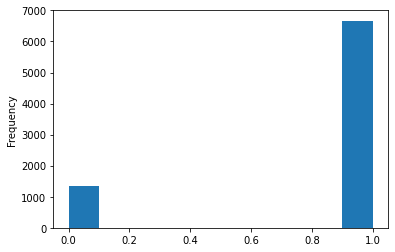

In [6]:
df_train['TARGET_5Yrs'].value_counts()/len(df_train)
df_train['TARGET_5Yrs'].astype(int).plot.hist()

**Note**: Target variable ('TARGET_5Yrs') is imbalanced. There are far more players that were played more or equal to 5 years than career years played less than 5 years. We can weight the classes by their representation in the data to reflect this imbalance. For example, we may consider SMOTE, Oversampling or other methods...


##### **[2.2]** Examine duplicate

In [7]:
# duplicate statistics
print("Train set")
print_duplicate(df_train, 'Id')
print()

print("Test set")
print_duplicate(df_test, 'Id')

Train set
There are 0 of duplicated columns.


,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs



Test set
There are 0 of duplicated columns.


,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV


**Note:** There are no duplicate in our trainset and testset

##### **[2.2]** Examine missing values

In [8]:
# Missing values statistics
print("Train set")
missing_values_table(df_train)

print()

print("Test set")
missing_values_table(df_test)

Train set
Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values



Test set
Your selected dataframe has 20 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


**Note:** There are no missing value in our train set and test set.

In [9]:
# check train columns and test columns
one_value_cols_train = [col for col in df_train.columns[:-1]]
one_value_cols_test = [col for col in df_test.columns]
one_value_cols_train == one_value_cols_test

True

**Note:** the columns in train and test are identical.


##### **[2.3]** Column types

In [10]:
# Display summary of train
# total values in each column, null/not null, datatype, memory occupied etc
print("Number of each type of column in train")
df_train.dtypes.value_counts()

print()

print("Number of each type of column in test")
df_test.dtypes.value_counts()

Number of each type of column in train


float64    18
int64       3
dtype: int64


Number of each type of column in test


float64    18
int64       2
dtype: int64

**Note:** TARGET_5Yrs is a categorical varaible, which has already been encoding, in Dtype int64.

##### **[2.4]** Display descriptive data of train and test dataframe

In [11]:
df_train.describe()

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,19.583700,...,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,3977.447579,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [12]:
df_test.describe()

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,7010.614109,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,19.234746,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,3954.173641,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,15.968989,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,1.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,-38.000000,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,3644.000000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,-0.000000,0.100000,8.500000,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,7062.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,19.400000,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,10402.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,30.250000,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,13792.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,73.800000,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


##### **[2.5]** EDA summary 

1. There are some columns has anomalies value. For example, MIN has max value in 73.8 in train and 68 in test, which is not likely, given 48mins/game. -> examine number of instances
2. FT% has max value > 100 in train and test, not possible -> examine number of instances.
3. Columns containing negative values in both train and test, but these values should not be negative: 
* Train set: GP, 3P Made, 3PA, 3P%, BLK, FT% 
* Test set: 3P Made, 3PA, 3P%, BLK
* Columns containing negative values in Train only: GP, FT%

### 3. Data visualization

Now that we have dealt with the categorical variable and the outliers.
We can understand the data better by looking for correlations between the features and the target. Calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

##### **[3.1]** Correlation between X and y

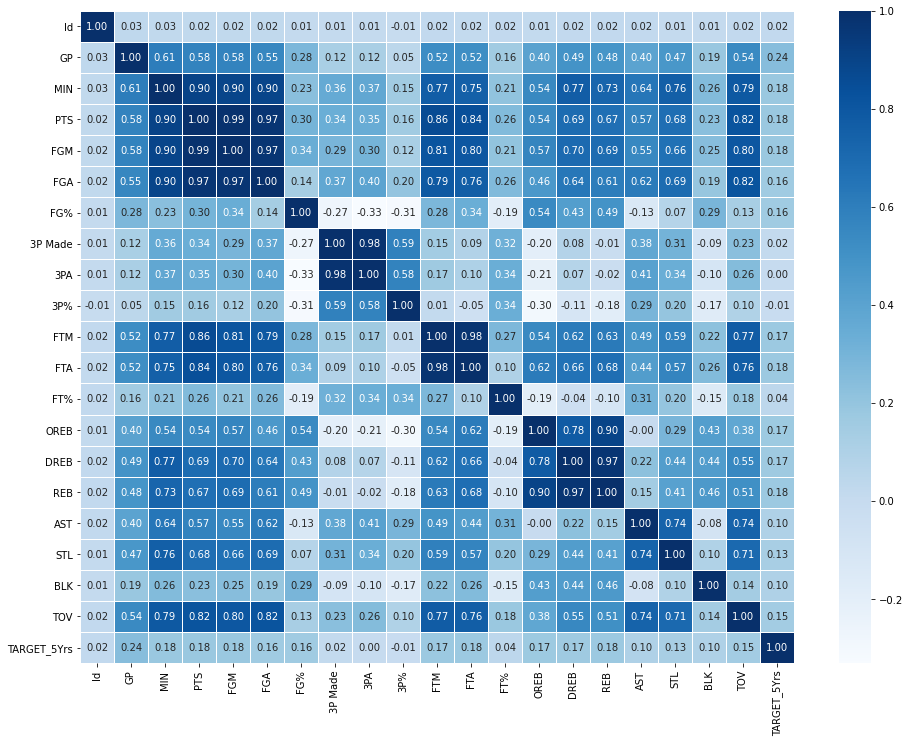

Most Positive Correlations with Target:
DREB           0.168065
OREB           0.172604
FTM            0.173913
REB            0.175627
FTA            0.176525
PTS            0.182004
MIN            0.182203
FGM            0.183568
GP             0.242108
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

Most Negative Correlations with Target:
3P%       -0.011977
3PA        0.003463
3P Made    0.015016
Id         0.018233
FT%        0.039429
AST        0.096771
BLK        0.098642
STL        0.128381
TOV        0.151240
FG%        0.158858
Name: TARGET_5Yrs, dtype: float64


In [13]:
corrs_graph(df_train)
corrs_X_y(df_train, 'TARGET_5Yrs')

**Note:** the 'GP' is the most positive correlation. (except 'TARGET_5Yrs' because the correlation of a variable with itself is always 1) 

##### **[3.2]** Distribution of all variables

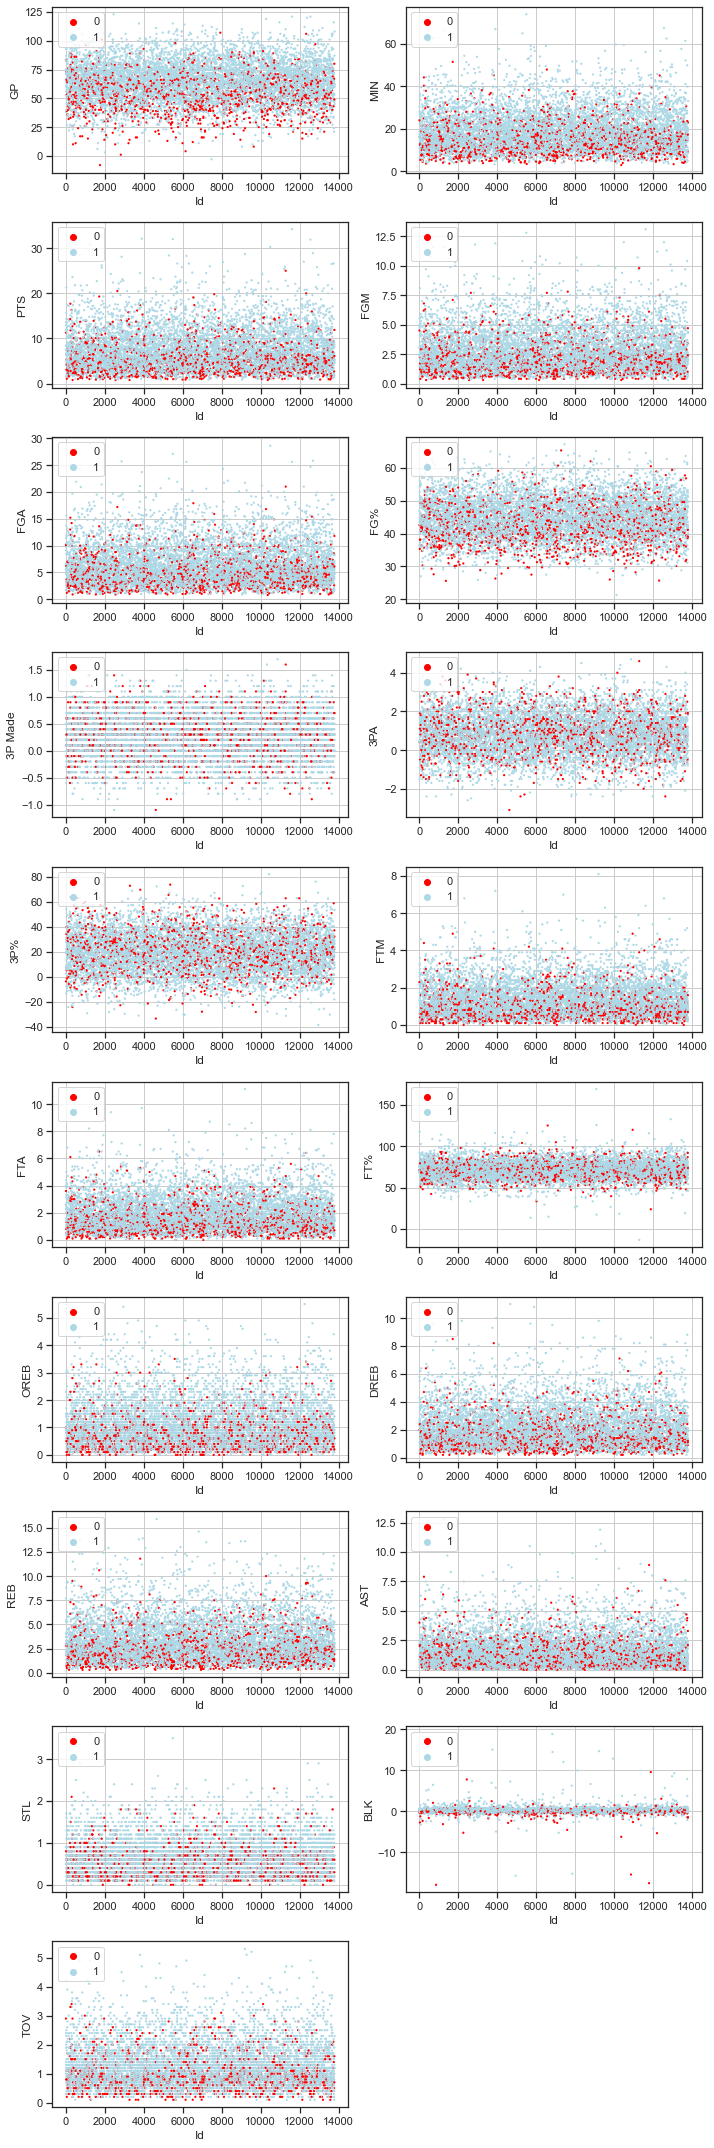

In [14]:
sns.set_theme(style="ticks")
plt.figure(figsize = (10,30))
nrow = 10
ncol = 2
i = 1 
for variable in df_train.drop(columns = ['Id','TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.scatterplot(x = "Id", y = variable, hue = "TARGET_5Yrs", data = df_train, 
                    legend = 'full',edgecolor = 'none', s = 5, palette=['red','lightblue']);
    i += 1
    plt.legend(loc=2)
plt.tight_layout()
plt.show();

**Note**: We can see for all features, variables with 'TARGET_5Yrs' = 0 (red points) are generally positioned lower than variables with 'TARGET_5Yrs' = 1.

##### **[3.3]** Violin plot of all variables

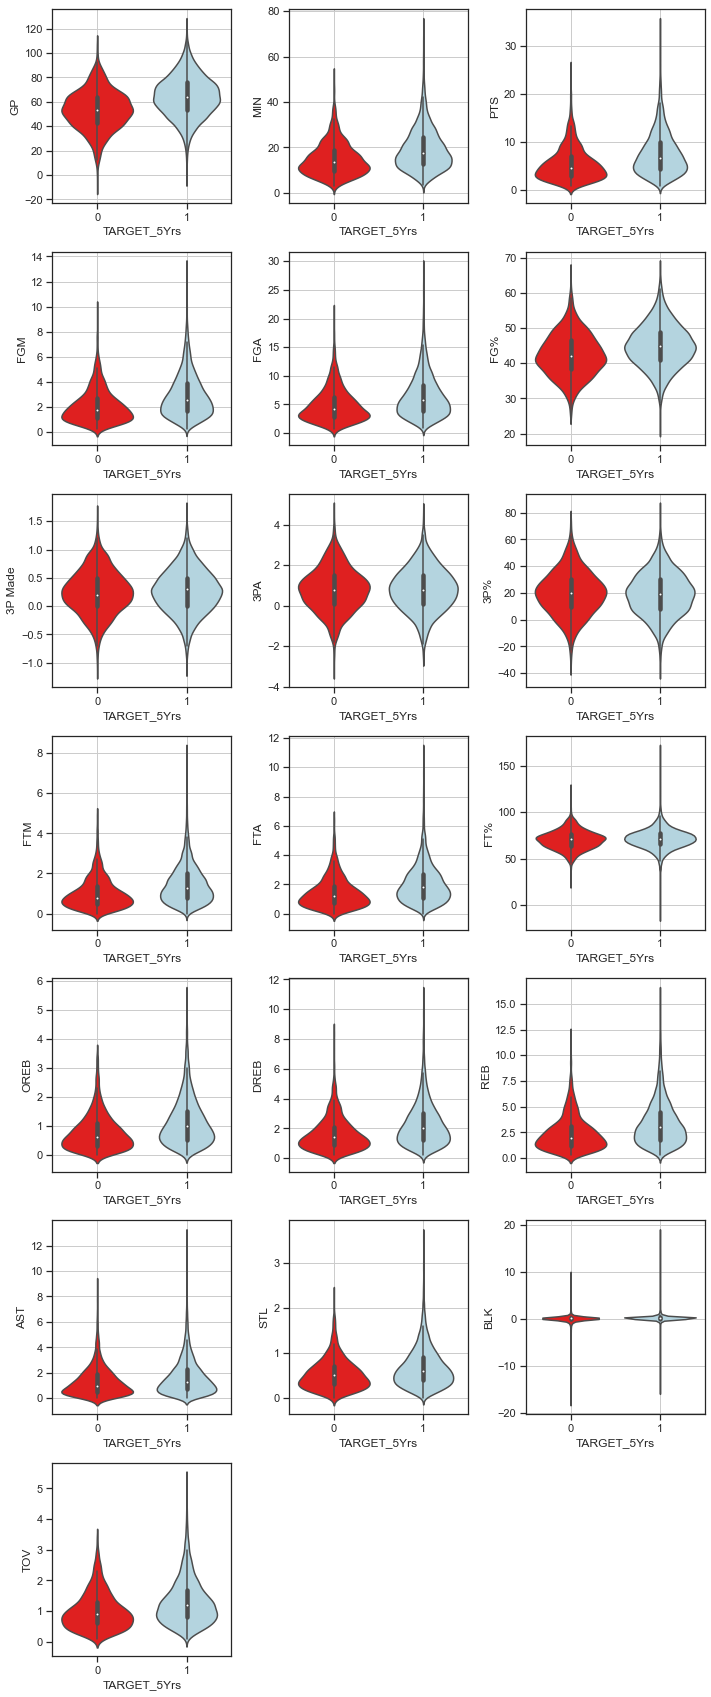

In [15]:
plt.figure(figsize = (10,30))
nrow = 9
ncol = 3
i = 1 
for variable in df_train.drop(columns = ['Id','TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.violinplot(x = "TARGET_5Yrs", y = variable, data = df_train, palette=['red','lightblue'])
    #plt.legend()
    i += 1
   # plt.legend(loc=2)
plt.tight_layout()
plt.show();

**Note:** From the violin plots, we can see almost all the variables generally have higher values when 'TARGET_5Yrs' = 1.
Especially: 'GP', 'MIN', 'PTS' 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'.

##### **[3.4]** Pairplot for selected variables

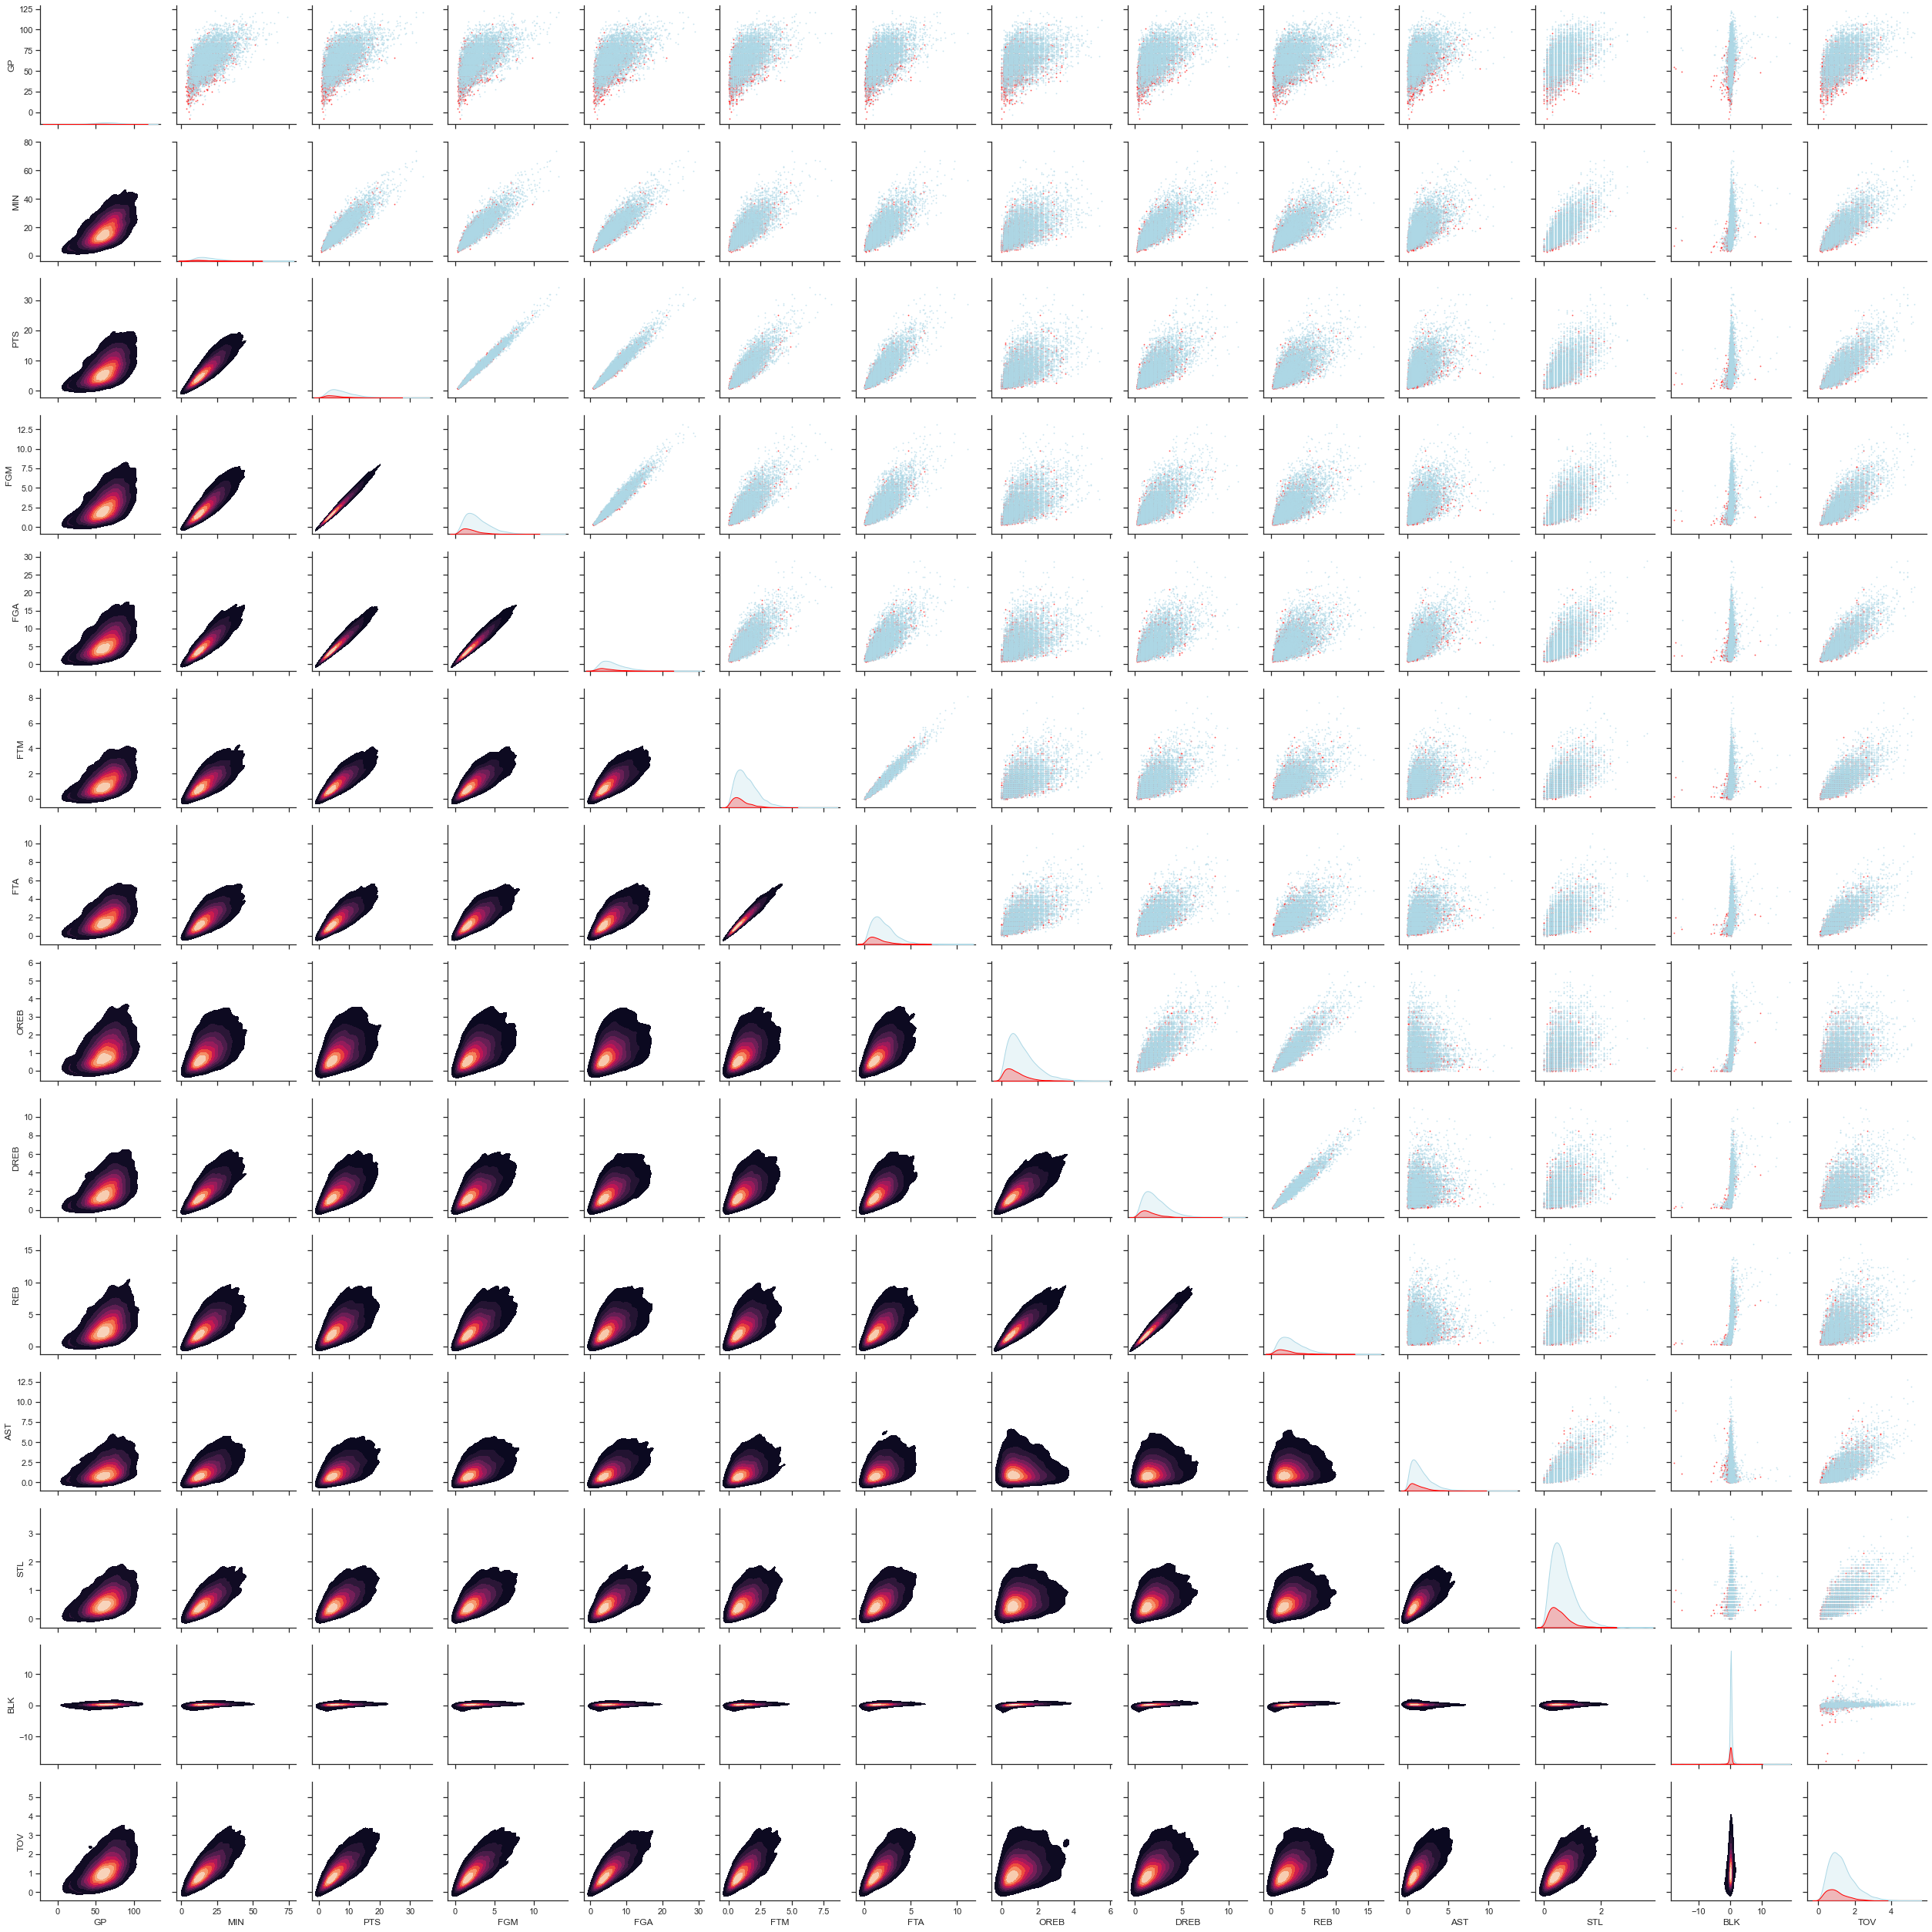

In [16]:
def infer_cmap(color):
    hues = ['red','lightblue']
    if color == hues[0]:
        return 'Reds'
    elif color == hues[1]:
        return 'lightBlues'

def kde_color_plot(x, y, **kwargs):
    cmap = infer_cmap(kwargs['color'])
    ax = sns.kdeplot(x, y, shade=True, shade_lowest=False, cmap=cmap, **kwargs)
    return ax

g = sns.PairGrid(df_train[['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs']], 
                 vars=('GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'), 
                 hue='TARGET_5Yrs', palette=['red','lightblue'])
g = g.map_upper(plt.scatter, s=1, alpha=0.5)
g = g.map_lower(kde_color_plot)
g = g.map_diag(sns.kdeplot, shade=True);
plt.tight_layout()
plt.show();

**Note:** In variabel 'GP', 'MIN', 'PTS' 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', we can see almost all the features have a positive relationship with the other features. TARGET_5Yrs = 1 is shown in blue, which is slightly higher than red TARGET_5Yrs = 0.
In addition, some variables' distribution is right skewed, for example 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST' and 'STL', which could be an indication of large amount of outliers with large values and potential usage of log transformation.

##### **[3.5]** Check the number of anomalies value

In [17]:
# MIN > 48
print("number of anomalies value of MIN > 48 in (train, test):")
len(df_train[df_train["MIN"] > 48].index), len(df_test[df_test["MIN"] > 48].index)

# FT% > 100
print("number of anomalies value in FT > 100 in (train, test):")
len(df_train[df_train["FT%"] > 100].index), len(df_test[df_test["FT%"] > 100].index)

# Find % of all columns containing negative values in train and test
print("% of negative values of each column in train")
(df_train < 0).sum(axis = 0)/df_train.shape[0]

print()

print("% of negative values of each column in test")
(df_test < 0).sum(axis = 0)/df_test.shape[0]


# Further investigate negative values
df_train[df_train["GP"] < 0].index
df_train[df_train["FT%"] < 0].index

name_list = ["3P Made", "3PA", "3P%", "BLK"]
for name in name_list:
    print(f"No. of Negative values in column '{name}' in (train, test): ({len(df_train[df_train[name] < 0].index)}, {len(df_test[df_test[name] < 0].index)})")


number of anomalies value of MIN > 48 in (train, test):


(56, 19)

number of anomalies value in FT > 100 in (train, test):


(58, 30)

% of negative values of each column in train


Id             0.000000
GP             0.000250
MIN            0.000000
PTS            0.000000
FGM            0.000000
FGA            0.000000
FG%            0.000000
3P Made        0.203625
3PA            0.207250
3P%            0.109750
FTM            0.000000
FTA            0.000000
FT%            0.000125
OREB           0.000000
DREB           0.000000
REB            0.000000
AST            0.000000
STL            0.000000
BLK            0.131000
TOV            0.000000
TARGET_5Yrs    0.000000
dtype: float64


% of negative values of each column in test


Id         0.000000
GP         0.000000
MIN        0.000000
PTS        0.000000
FGM        0.000000
FGA        0.000000
FG%        0.000000
3P Made    0.204001
3PA        0.203475
3P%        0.114504
FTM        0.000000
FTA        0.000000
FT%        0.000000
OREB       0.000000
DREB       0.000000
REB        0.000000
AST        0.000000
STL        0.000000
BLK        0.120032
TOV        0.000000
dtype: float64

Int64Index([5323, 7400], dtype='int64')

Int64Index([3059], dtype='int64')

No. of Negative values in column '3P Made' in (train, test): (1629, 775)
No. of Negative values in column '3PA' in (train, test): (1658, 773)
No. of Negative values in column '3P%' in (train, test): (878, 435)
No. of Negative values in column 'BLK' in (train, test): (1048, 456)


##### **[3.6]** Data visualization summary

There are a lot of anomalies values, especially negative values in the dataset. We will fill values with np.nan and create boolean columns indicating whether or not the values was anomalous in later steps. 
Considering this dataset has no missing value originally, filling with np.nan would be sufficient to distinguish anomalies, it would also provide potential to be filled by different values (0/mean/median/mode) in later section.

### 4. Data Cleaning

* Recalculate some variables that are calculated incorrectly
* Fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

Re-read data in this section for future convienience (skip EDA and start from this section).

##### **[4.1]** Prepare dataset for following steps

Combine train and test X in order to apply the feature transformation pipeline to the entire dataset.

In [18]:
# Read data in notebook
df_train = pd.read_csv("data/raw/train.csv", index_col=0)
print('Training data shape: ', df_train.shape)

df_test = pd.read_csv("data/raw/test.csv", index_col=0)
print('Testing data shape: ', df_test.shape)

# Split X and y, X is all features, y is our target
X_train = df_train.drop(['TARGET_5Yrs'], axis=1)
y_train = df_train['TARGET_5Yrs']
X_test = df_test

# Combine train and test X
all_X = pd.concat([X_train, X_test]).reset_index(drop=False).set_index('Id')

Training data shape:  (8000, 20)
Testing data shape:  (3799, 19)


##### **[4.2]** Recalculate variables

We find FT% calculated based on FTM and FTA is having a maximum value of 200% which is impossible, which means there are hidden problems in FTM & FTA. Also, NBA official highest 3P% is around 45%, which is much lower than the maximum 82.1% here, recalculate 3P%.

Recalculate four variables FT%, 3P%, FG%, REB contained in the raw test dataset, which can be calculated based on the other variables in the same dataset.

In [19]:
# recalculate FT%, since the FT% > 100 is not possible
all_X['FT%'] = all_X['FTM'] / all_X['FTA'] * 100

# recalculate 3P%, since NBA official highest 3P% is around 45%
all_X['3P%'] = all_X['3P Made'] / all_X['3PA'] * 100

# recalculate FG%, since above 2 columns are wrong, check for correctness
all_X['FG%'] = all_X['FGM'] / all_X['FGA'] * 100

# recalculate REB
all_X['REB'] = all_X['OREB'] + all_X['DREB']

# # check step, uncomment to see 
# all_X.describe()
# all_X.info()

Check columns after recalculating four variables.

In [20]:
# # check step, uncomment to see 

# # Use if need:
# # pd.options.display.max_rows = 8000

# # find 3P% = inf - 162 rows
# print("Rows of 3P% = inf")
# all_X[np.isinf(all_X['3P%'])]
# print()

# # 3P Made > 3PA, 2221 rows
# print("Rows of 3P Made > 3PA")
# all_X[all_X['3P Made'] > all_X['3PA']]
# print()

# # 3P% = nan, 163 rows
# print("Rows of 3P% = nan")
# all_X[np.isnan(all_X['3P%'])]
# print()

# # FG% = nan, 0 rows
# print("Rows of FG% = nan")
# all_X[np.isnan(all_X['FG%'])]
# print()

# # FT = nan,  9 rows
# print("Rows of FT = nan")
# all_X[np.isnan(all_X['FT%'])]
# print()

# # Check info
# print("Check info")
# all_X.info()
# print()

# # Check dataframe
# print("Check describe")
# all_X.describe()

##### **[4.3]** Fill % realated anomalies value with np.nan

From the result above, we find there are still a lot of anomalies values. For example, 3P made is higher than 3PA, which is impossible. We will change it as np.nan if the value is not correct.

In [21]:
# Use if need:
# pd.set_option('display.max_columns', None)

# Change inf as nan
all_X.loc[np.isinf(all_X['3P%']), '3P%'] = np.nan

# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic 
cal_variables = [['3P Made', '3PA', '3P%'],
          ['FTM', 'FTA', 'FT%'],
          ['FGM', 'FGA', 'FG%']]
add_anom_higher(all_X, cal_variables)

# Recheck dataframe
all_X.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
count,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9578.000000,9578.000000,9294.000000,11735.000000,...,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,62.802356,18.600347,7.286711,2.816171,6.254191,44.639429,0.382888,1.159543,33.778950,1.396651,...,1.628367,0.650267,0.249241,1.257810,0.188236,0.188236,0.188236,0.005424,0.005424,0.005424
std,17.128705,8.868520,4.310929,1.691763,3.582845,6.230051,0.304823,0.820547,25.624378,0.926852,...,1.349378,0.408566,0.767327,0.719774,0.390917,0.390917,0.390917,0.073452,0.073452,0.073452
min,-8.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.300000,-0.300000,-200.000000,0.000000,...,0.000000,0.000000,-17.900000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,12.050000,4.100000,1.600000,3.600000,40.322581,0.200000,0.500000,28.571429,0.700000,...,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,16.900000,6.400000,2.400000,5.500000,44.444444,0.300000,1.100000,33.333333,1.200000,...,1.300000,0.600000,0.200000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.648649,0.600000,1.700000,38.461538,1.900000,...,2.200000,0.900000,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,126.000000,73.800000,34.200000,13.400000,28.900000,81.250000,1.700000,4.700000,300.000000,8.100000,...,12.800000,3.600000,18.900000,5.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The described table looks reasonable after the above step.

Create a function to check the missing values in the dataset.

In [22]:
# Missing values statistics
print("Train set")
missing_values_table(all_X)

Train set
Your selected dataframe has 25 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
3P%,2505,21.2
3P Made,2221,18.8
3PA,2221,18.8
FT%,73,0.6
FTM,64,0.5
FTA,64,0.5


3P%, 3P Made, 3PA has the highest percentage of missing values based on the total values, around 20%. In other words, there are about 20% of anomalies values in each of these columns. Let's double check the missing values.

In [23]:
all_X[np.isnan(all_X['3P Made'])]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
Id,,,,,,,,,,,,,,,,,,,,,
5342,75,21.8,10.5,4.2,7.9,53.164557,NaN,NaN,NaN,2.4,...,0.7,0.5,0.6,1.4,1,1,1,0,0,0
1961,88,20.0,8.8,3.7,8.7,42.528736,NaN,NaN,NaN,2.0,...,1.8,0.4,0.3,1.1,1,1,1,0,0,0
2677,70,20.6,7.0,3.2,5.4,59.259259,NaN,NaN,NaN,0.7,...,0.6,0.4,0.7,1.2,1,1,1,0,0,0
13144,41,9.8,2.3,0.9,2.3,39.130435,NaN,NaN,NaN,0.9,...,0.2,0.3,0.4,0.4,1,1,1,0,0,0
3062,83,8.5,2.2,0.9,1.8,50.000000,NaN,NaN,NaN,0.5,...,1.3,0.4,0.2,0.8,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8148,64,10.4,3.1,1.3,3.6,36.111111,NaN,NaN,NaN,0.5,...,1.4,0.5,-0.0,0.9,1,1,1,0,0,0
8165,59,8.6,2.8,1.3,2.3,56.521739,NaN,NaN,NaN,0.3,...,0.0,0.1,0.6,0.2,1,1,1,0,0,0
8166,60,11.7,7.2,3.2,5.7,56.140351,NaN,NaN,NaN,0.8,...,0.5,0.5,0.2,1.0,1,1,1,0,0,0


In [24]:
# Check 3P Made_anom not nan and 3P%_anom is nan, 28 rows
print("3P Made_anom!=nan and 3P%_anom == nan ")
all_X[~np.isnan(all_X['3P Made_anom'])& np.isnan(all_X['3P%_anom'])]

3P Made_anom!=nan and 3P%_anom == nan 


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
Id,,,,,,,,,,,,,,,,,,,,,


In [25]:
all_X[all_X['3P%'] > 100]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
Id,,,,,,,,,,,,,,,,,,,,,
6871,61,20.0,11.7,4.9,11.9,41.176471,-0.3,-0.2,150.0,1.8,...,2.2,1.2,0.4,3.3,0,0,0,0,0,0
3585,43,11.2,4.3,1.5,3.9,38.461538,-0.2,-0.1,200.0,1.1,...,1.5,0.7,-0.1,0.8,0,0,0,0,0,0
3396,89,23.8,6.7,2.6,5.9,44.067797,-0.2,-0.1,200.0,1.4,...,1.6,0.8,0.3,1.6,0,0,0,0,0,0
1854,52,26.7,10.2,3.5,8.6,40.697674,-0.2,-0.1,200.0,3.5,...,2.9,1.4,0.3,1.3,0,0,0,0,0,0
7381,71,32.3,12.3,4.8,10.6,45.283019,-0.2,-0.1,200.0,3.0,...,1.3,1.5,5.3,2.1,0,0,0,0,0,0
2854,57,9.7,3.0,1.1,2.8,39.285714,-0.3,-0.2,150.0,0.8,...,1.1,0.6,-0.2,0.7,0,0,0,0,0,0
7783,58,14.6,6.6,2.6,5.5,47.272727,-0.2,-0.1,200.0,1.3,...,1.9,0.5,0.2,1.4,0,0,0,0,0,0
9022,65,18.8,5.1,2.0,5.2,38.461538,-0.2,-0.1,200.0,1.2,...,1.3,0.5,0.3,1.3,0,0,0,0,0,0
5788,61,18.4,9.0,3.8,7.6,50.000000,-0.2,-0.1,200.0,1.9,...,1.5,0.6,0.3,1.7,0,0,0,0,0,0


There are a lot of 3P% above 100,  3P Made and 3PA is all negative in these columns, which is not possible. Need to fill the negative anomalies value with np.nan.

##### **[4.4]** Fill negative anomalies value with np.nan

In [26]:
# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic
variables = X_train

# Create anomalous flag columns and replace the anomalous values with nan
add_anom_negative(all_X, variables)

# Recheck dataframe
all_X.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom
count,11797.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9079.000000,9319.000000,9175.000000,11735.000000,...,10295.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,62.813936,18.600347,7.286711,2.816171,6.254191,44.639429,0.411257,1.195568,35.326419,1.396651,...,0.358446,1.257810,0.230528,0.210187,0.198322,0.005424,0.005424,0.005424,0.000170,0.127468
std,17.107019,8.868520,4.310929,1.691763,3.582845,6.230051,0.287066,0.802446,21.388600,0.926852,...,0.629450,0.719774,0.421189,0.407459,0.398753,0.073452,0.073452,0.073452,0.013019,0.333511
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,...,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,12.050000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,28.571429,0.700000,...,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,16.900000,6.400000,2.400000,5.500000,44.444444,0.400000,1.100000,33.333333,1.200000,...,0.300000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.648649,0.600000,1.700000,38.461538,1.900000,...,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,126.000000,73.800000,34.200000,13.400000,28.900000,81.250000,1.700000,4.700000,300.000000,8.100000,...,18.900000,5.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
all_X[all_X['3P%'] < 0]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom
Id,,,,,,,,,,,,,,,,,,,,,


The raw dataset looks more reasonable now after the above step.

##### **[4.5]** Fill positive anomalies value with np.nan

By research, the historical highest records for all below columns are, for columns with values larger than below values, substitute with np.nan.
* GP: 82 per season. Assume and also check diagram 
* MIN: 45.8 Wilt Chamberlain
* PTS: 30.1 Michael Jordan
* FGM: 20 Wilt Chamberlain
* FGA: 23.8 Elgin Baylor
* FG%: 72.8 Robert Williams III
* 3P Made: 3.78 Stephen Curry
* 3PA: 12.7 Stephen Curry
* 3P%: 45 Steve Kerr
* FTM: 7.8 Bob Pettit
* FTA: 17 Wilt Chamberlain
* FT%: 90.69 Stephen Curry
* OREB: 5.1 Moses Malone
* DREB: 14.7 Rudy GobertUTA
* REB: 22.89 Wilt Chamberlain
* AST: 11.19 Magic Johnson
* STL: 2.71 Alvin Robertson
* BLK:  3.83 Hakeem Olajuwon
* TOV: 4.1 Russell Westbrook


In [28]:
# Create a dic with highest records for each variable
max_dic = {
    'GP': 82,
    'MIN': 45.8,
    'PTS': 30.1,
    'FGM': 20,
    'FGA': 23.8,
    'FG%': 72.8,
    '3P Made': 3.78,
    '3PA': 12.7,
    '3P%': 45,
    'FTM': 7.8,
    'FTA': 17,
    'FT%': 90.69,
    'OREB': 5.1,
    'DREB': 14.7,
    'REB': 22.89,
    'AST': 11.19,
    'STL': 2.71,
    'BLK': 3.83,
    'TOV': 4.1
}

# Create anomalous flag columns and replace the anomalous values with nan
add_anom_positive(all_X, max_dic)


# recheck dataframe
all_X.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom
count,10320.000000,11688.000000,11790.000000,11799.000000,11783.000000,11798.000000,9079.000000,9319.000000,8092.000000,11734.000000,...,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,58.771996,18.280399,7.267939,2.816171,6.227752,44.636326,0.411257,1.195568,30.033281,1.396080,...,0.125350,0.130943,0.009408,0.000763,0.001356,0.000085,0.000593,0.000170,0.000424,0.002712
std,14.020545,8.255794,4.258557,1.691763,3.512286,6.221189,0.287066,0.802446,10.459873,0.924823,...,0.331129,0.337353,0.096539,0.027609,0.036801,0.009206,0.024351,0.013019,0.020582,0.052009
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.750000,12.000000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,27.272727,0.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,60.000000,16.800000,6.400000,2.400000,5.500000,44.444444,0.400000,1.100000,33.333333,1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,23.200000,9.500000,3.700000,8.100000,48.639264,0.600000,1.700000,36.363636,1.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,82.000000,45.800000,30.100000,13.400000,23.700000,72.413793,1.700000,4.700000,45.000000,7.800000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The raw dataset looks more reasonable now after the above step.

##### **[4.6]** Correletation after above progress

Separate dataset to look the correlation between the target and other features.

In [29]:
# Seperate dataset
X_train = all_X.iloc[:len(y_train), :]
X_test = all_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
col_name = list(X_train.columns)
y_train = df_train['TARGET_5Yrs']
data_train = X_train
data_train['TARGET_5Yrs'] = y_train

((8000, 35), (8000,), (3799, 35))

In [30]:
# Display correlations with Target
corrs_X_y(data_train, 'TARGET_5Yrs')

Most Positive Correlations with Target:
DREB           0.168065
OREB           0.172672
FTM            0.174419
FTA            0.176300
REB            0.179092
MIN            0.181619
PTS            0.182391
FGM            0.183568
GP             0.222941
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

Most Negative Correlations with Target:
BLK_anom       -0.102087
FT%_anom       -0.034973
FTA_anom       -0.022245
FTM_anom       -0.021237
3P Made_anom    0.003684
AST_anom        0.007065
3PA_anom        0.007678
OREB_anom       0.008653
STL_anom        0.011172
3PA             0.012865
Name: TARGET_5Yrs, dtype: float64


From the correlation list, we can see that all original columns are positively correlated with the target variable.

In [31]:
# save cleaned data set to all_X.csv
all_X.to_csv("data/processed/all_X.csv", index = False)

##### **[4.7]** Data Cleaning summary

The dataset was cleaned by:
* recalculating percentage columns and REB
* identify anomalies/outliers by % > 100%, values < 0 and historical highest values
* replace anomalies by np.nan and create boolean columns to locate corresponding rows

### 5. Add Features

In [32]:
all_X_domain = all_X.copy()

##### **[5.1]** Add domain knowledge features 

2P is a vital feature to evaluate players. We will make three features 2P Made, 2PA, 2P% similar to 3P in this dataset.

In [33]:
# Add '2P' features
# 2-Point Field Goals: 2P Made = FGM - 3P Made
all_X_domain['2P Made'] = all_X_domain['FGM'] - all_X_domain['3P Made']

# 2-Point Field Goal Attempts: 2PA = FGA - 3PA
all_X_domain['2PA'] = all_X_domain['FGA'] - all_X_domain['3PA']

# 2-Point Field Goal Percentage: 2P% = 2P Made / 2PA
all_X_domain['2P%'] = all_X_domain['2P Made'] / all_X_domain['2PA'] * 100

In [34]:
# Fill % realated anomalies value with np.nan, make dataset more reasonable.
# Same process as 4.3, 4.4, 4.5
# Use if need:
# pd.set_option('display.max_columns', None)

# Change inf as nan
all_X_domain.loc[np.isinf(all_X_domain['2P%']), '2P%'] = np.nan

# Create anomalous flag columns and replace the anomalous values with nan
cal_variables = [['2P Made', '2PA', '2P%']]

add_anom_higher(all_X_domain, cal_variables)

# fill negative anamalies
variables = ['2P Made', '2PA', '2P%']        
add_anom_negative(all_X_domain, variables)

# fill % larger than 72.8 (threshold from section 4.5)
max_dic = {'2P%': 72.8}    
add_anom_positive(all_X_domain, max_dic)

In [35]:
# Add other knowledge features
all_X_domain = add_knowledge(all_X_domain)

In [36]:
# Save dataset
all_X_domain.to_csv("data/processed/all_X_domain.csv", index = False)

##### **[5.2]** Add Per 48 Minutes features

In [37]:
# crearte a copy
all_X_per = all_X_domain.copy()

Add "per n minutes” to most totals to get the corresponding per-n-minutes average. Features not include 'GP', 'MIN', '3P%', 'FT%', 'FG%'.

In [38]:
# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic with highest records for each variable
variables = df_train.drop(['GP', 'MIN', '3P%', 'FT%', 'FG%', 'TARGET_5Yrs'], axis=1)

# Create anomalous flag columns and replace the anomalous values with nan
for col in variables:
    all_X_per[f'{col}_per'] = all_X_per[col] / all_X_per['MIN'] *48

In [39]:
# Save dataset
all_X_per.to_csv("data/processed/all_X_per.csv", index = False)

##### **[5.3]** Add Log and squres features

In [40]:
# Make a copy
final_X = all_X_per.copy()
final_X.shape

(11799, 91)

Log transformation and square transformation. Log transformation is used for those variables that are left or right skewed in distribution to make them normalized, and square transformation is trying to dig out more hidden features in the dataset.

In [41]:
# Add log fetures
log_features = final_X.columns
final_X = add_logs(final_X, log_features)

In [42]:
# Add squared fetures
squared_features = final_X.columns
final_X = add_squares(final_X, squared_features)

In [43]:
# Save dataset
final_X.to_csv("data/processed/final_X.csv", index = False)

##### **[5.4]** Correlation after add features

In [44]:
# Seperate dataset
X_train = final_X.iloc[:len(y_train), :]
X_test = final_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
# col_name = list(X_train.columns)
# y_train = df_train['TARGET_5Yrs']
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 364), (8000,), (3799, 364))

In [45]:
# Display correlations with Target
corrs_X_y(df_train, 'TARGET_5Yrs')

Most Positive Correlations with Target:
DREB           0.168065
OREB           0.172604
FTM            0.173913
REB            0.175627
FTA            0.176525
PTS            0.182004
MIN            0.182203
FGM            0.183568
GP             0.242108
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

Most Negative Correlations with Target:
3P%       -0.011977
3PA        0.003463
3P Made    0.015016
FT%        0.039429
AST        0.096771
BLK        0.098642
STL        0.128381
TOV        0.151240
FG%        0.158858
FGA        0.162389
Name: TARGET_5Yrs, dtype: float64


##### **[5.5]** Add features summary

After adding domain knowledge features, per 48 MIN features and taking log and square of all these variables, we can see from the last step the dominating variables are GP, MIN and their related variables.

In the next section these features will be screened and selected.

### 6. Feature Selection

Re-import packages and raw data sets here for future convienience. Because EDA and feature engineering stays pretty much the same, for experiment with different combination of dataset and selection methods, group members can starts from Section 6 here.

Data set dictionary:

* all_X.csv - Cleaned data: anomalies filled with np.nan and coolean '_anom' columns added
* all_X_domain.csv - all_X + Domain knowledge features added
* all_X_per.csv - all_X_domain + Per minute Features added
* final_X.csv - Log and square transformation applied to all previously added/ existing columns

Note: all these csv files contains np.nan value, need to fill with preferred value before applying to models, method will be shown below.

##### **[6.1]** Read data

In [46]:
# Essentials for for data manipulation
import pandas as pd
import numpy as np

# self defined functions
from src.data.explore import print_head, print_duplicate, missing_values_table
from src.visualization.visualize import corrs_graph, corrs_X_y, collinear_col
from src.features.build_features import add_anom_higher, add_anom_negative, add_anom_positive, add_logs, add_squares, add_knowledge
from src.models.basic_model_test import basic_lgb_model, plot_feature_importances
from src.data.prep_model import transform, find_optimal_cluster, prep_model_data

# Misc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler

# Other
import warnings
warnings.filterwarnings(action="ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Use if need
# pd.set_option('display.max_columns', None)
# pd.options.display.max_seq_items = 8000
# pd.options.display.max_rows = 200

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Change to dataset you want to use
final_X = pd.read_csv("data/processed/final_X.csv")

##### **[6.2]** By low information

Use the built-in featuretools selection function to remove columns that only have one unique value or have all null values.

In [48]:
from featuretools import selection
final_X_raw = final_X
# Remove low information features
final_X = selection.remove_low_information_features(final_X_raw)
print('Removed %d features from training features'  % (final_X_raw.shape[1] - final_X.shape[1]))
final_X.shape

Removed 0 features from training features


(11799, 364)

##### **[6.3]** By high missing value

Remove columns that has percentage of missing value higher than 75%.

In [49]:
# Find missing columns
missing_values_table(final_X)

Your selected dataframe has 364 columns.
There are 260 columns that have missing values.


,Missing Values,% of Total Values
VA_log,5230,44.3
VA_log_sq,5230,44.3
EWA_log_sq,5221,44.2
EWA_log,5221,44.2
VA,5219,44.2
EWA,5219,44.2
EWA_sq,5219,44.2
VA_sq,5219,44.2
PER_log_sq,4148,35.2
PER_log,4148,35.2


There are no features with percentage of total value higher than 75%.

##### **[6.4]** By high collinear variable:

##### **[6.4.1]** with self-defined threshold

In [50]:
# Drop collinear variables with correlation > 0.9 
# Seperate dataset
X_train = final_X.iloc[:len(y_train), :]
X_test = final_X.iloc[len(y_train):, :]
# X_train.shape, y_train.shape, X_test.shape
train = X_train
train['TARGET_5Yrs'] = y_train

# # Display correlations with Target
# corrs_X_y(X_train, 'TARGET_5Yrs')

In [51]:
cols_to_remove = collinear_col(train, 0.9)

# Remove columns
final_X_corrs1 = final_X.drop(columns = cols_to_remove)
final_X_corrs1.shape

Number of columns to remove:  304


(11799, 60)

In [52]:
# Test self-defined drop method (corrs drop 1)
data = final_X_corrs1
y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']

train = data.iloc[:len(y_train), :]
test = data.iloc[len(y_train):, :]

feature_importances_1, zero_features_1, metrics_1 = basic_lgb_model(train, test, y_train)
metrics_1

Training Data Shape:  (8000, 60)
Testing Data Shape:  (3799, 60)


,fold,train,valid
0,0,0.918078,0.698557
1,1,0.839175,0.701820
2,2,0.809965,0.717754
3,3,0.837577,0.688734
4,4,0.913821,0.690552
5,overall,0.863723,0.692560


In [53]:
# Save dataset
final_X_corrs1.to_csv("data/processed/final_X_corrs1.csv", index = False)

##### **[6.4.2]** with built-in function

In [54]:
# Drop collinear variables with built-in function
# remove highly correlated features by selection
final_X_corrs2 = selection.remove_highly_correlated_features(final_X, features=None, pct_corr_threshold=0.90, features_to_check=None, features_to_keep=None)
final_X_corrs2.shape
print('Removed %d features' % (final_X.shape[1]- final_X_corrs2.shape[1]))

(11799, 58)

Removed 306 features


In [55]:
data = final_X_corrs2

y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']
train = data.iloc[:len(y_train), :]
test = data.iloc[len(y_train):, :]

feature_importances_2, zero_features_2, metrics_2 = basic_lgb_model(train, test, y_train)
metrics_2

Training Data Shape:  (8000, 58)
Testing Data Shape:  (3799, 58)


,fold,train,valid
0,0,0.868246,0.696492
1,1,0.839226,0.701748
2,2,0.809965,0.717754
3,3,0.837577,0.688734
4,4,0.914224,0.690958
5,overall,0.853848,0.692864


In [56]:
# Save dataset
final_X_corrs2.to_csv("data/processed/final_X_corrs2.csv", index = False)

##### **[6.4.3]** comparision between two method

In [57]:
# comparision between corrs1 and corrs2
print("Features contain in final_X_corrs1 but not in final_X_corrs2:")
[x for x in final_X_corrs1 if x not in list(final_X_corrs2)]
print()

print("Features contain in final_X_corrs2 but not in final_X_corrs1:")
[x for x in final_X_corrs2 if x not in list(final_X_corrs1)]

Features contain in final_X_corrs1 but not in final_X_corrs2:


['FG%_anom_log', 'FG%_anom_sq', 'FG%_anom_log_sq']


Features contain in final_X_corrs2 but not in final_X_corrs1:


['3PAr_sq']

Based on the above observation, self-defined method has higher validation and lower train set AUC scores.


final_X_corrs2.csv dataset will be used in the next step.


##### **[6.5]** List of the new features 

In [58]:
# List of the original features 
original_features = df_train.drop(['TARGET_5Yrs'], axis=1)

created_features = []

# Iterate through the top 100 features
for feature in feature_importances_2['feature'][:30]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 30 features were created' % len(created_features))
created_features

20 of the top 30 features were created


['EFF/48',
 'BLK_per',
 'PPP',
 'EFF/GP',
 'ORB%',
 '3PAr',
 'TOV%',
 'FTM_per',
 'STL%',
 'ASTR',
 '2P%',
 'STL/TOV',
 'DRB%',
 'TOV_per',
 'FTr',
 'AST/TOV',
 'FTMr',
 'USGr',
 'APM',
 'FT_miss']

##### **[6.6]** By feature importance

Using corrs2 for next step

In [59]:
# load dataset
data = pd.read_csv("data/processed/final_X_corrs2.csv").reset_index(drop=True)
y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']

train = data.iloc[:len(y_train), :]
test = data.iloc[len(y_train):, :]

In [60]:
print('There are %d features with 0.0 importance' % len(zero_features_2))
train_f1 = train.drop(columns = zero_features_2)
test_f1 = test.drop(columns = zero_features_2)

print('Train shape after drop: ', train_f1.shape)
print('Test shape after drop: ', test_f1.shape)

There are 20 features with 0.0 importance
Train shape after drop:  (8000, 38)
Test shape after drop:  (3799, 38)


In [61]:
# Save dataset
train_f1.to_csv("data/processed/train_f1.csv", index = False)
test_f1.to_csv("data/processed/test_f1.csv", index = False)

##### **[6.7]** Evaluate the resulting model after dropping 0 importance feature

In [62]:
## get dataset
train = pd.read_csv("data/processed/train_f1.csv")
test = pd.read_csv("data/processed/test_f1.csv")
y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']

feature_importances, zero_features, metrics = basic_lgb_model(train, test, y_train)
metrics

Training Data Shape:  (8000, 38)
Testing Data Shape:  (3799, 38)


,fold,train,valid
0,0,0.868246,0.696492
1,1,0.839226,0.701748
2,2,0.809965,0.717754
3,3,0.837574,0.688748
4,4,0.914224,0.690958
5,overall,0.853847,0.692865


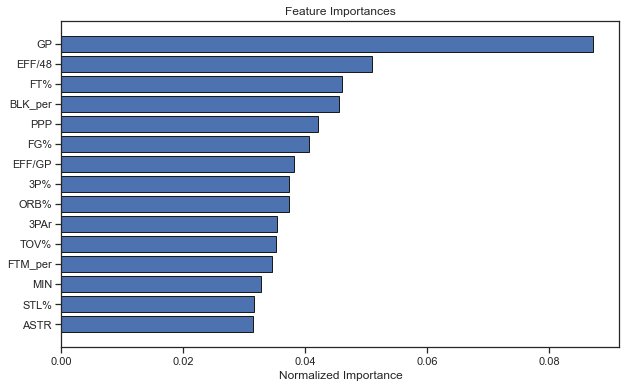

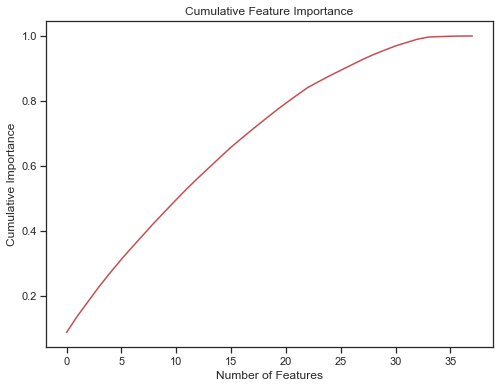

27 features required for 0.90 of cumulative importance


In [63]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [64]:
print('There are %d features with 0.0 importance' % len(zero_features))

There are 0 features with 0.0 importance


In [65]:
# save to csv
final_X_dropped = pd.concat([train, test])
final_X_dropped.to_csv("data/processed/final_X_dropped.csv", index = False)

Now all features in the dataset has importance > 0. We will keep and use these feature for modeling. 
In this dataset we:

* drop all collinear features with correlation coefficient grater than 0.9
* droped features with missing value greater than 75%
* removed no imformation features

##### **[6.8]** Reintroduce domain knowledge 'PER', 'PPER', 'NPER'

After group discussion, the features: 'PER', 'PPER' are 'NPER' considered important to the model even it is dropped in previous section, so we added these features back.

In [66]:
# Load dataset
train = pd.read_csv("data/processed/train_f1.csv")
test = pd.read_csv("data/processed/test_f1.csv")
y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']
all_X_domain = pd.read_csv("data/processed/all_X_domain.csv")

train.shape, test.shape, all_X_domain.shape


((8000, 38), (3799, 38), (11799, 77))

In [67]:
# Combine train and test X
final_add = pd.concat([train, test]).reset_index(drop=True)
final_add['PER'] = all_X_domain['PER']
final_add['PPER'] = all_X_domain['PPER']
final_add['NPER'] = all_X_domain['NPER']


In [68]:
# Save dataset
final_add.to_csv("data/processed/final_add.csv", index = False)

In [69]:
# Evaluate current dataset
data = pd.read_csv("data/processed/final_add.csv").reset_index(drop=True)
y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']

train = data.iloc[:len(y_train), :]
test = data.iloc[len(y_train):, :]

feature_importances, zero_features, metrics = basic_lgb_model(train, test, y_train)
metrics

Training Data Shape:  (8000, 41)
Testing Data Shape:  (3799, 41)


,fold,train,valid
0,0,0.933389,0.700535
1,1,0.839106,0.695195
2,2,0.885707,0.719282
3,3,0.833414,0.688326
4,4,0.867496,0.684512
5,overall,0.871823,0.695456


In [70]:
feature_importances

,feature,importance
0,GP,92.8
33,BLK_per,58.0
7,FT%,55.8
27,PPP,53.6
26,EFF/48,48.2
15,2P%,46.6
3,FG%,45.2
24,ORB%,45.0
30,TOV%,43.2
18,3PAr,42.4


We can see both the train and validation auc score are higher than before. Which indicates reintroducing the three variables are having some positive effects on the model.

In [71]:
# Save dataset
train.to_csv("data/processed/train_add.csv", index = False)
test.to_csv("data/processed/test_add.csv", index = False)

### 7. K mean cluster

##### **[7.1]** Prepare dataset

In [72]:
# Load train set
train = pd.read_csv("data/processed/train_add.csv")
y_train = pd.read_csv("data/raw/train.csv")['TARGET_5Yrs']

# Load test set
test = pd.read_csv("data/processed/test_add.csv")

# Check shape of train and test
train.shape, test.shape

((8000, 41), (3799, 41))

Imputer and scaler can be selected as need.

In [73]:
# fill imputer in 'mean', 'median', 'most_frequent', 'constant'
imputer = 'most_frequent'

# fill scaler in StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()
scaler = StandardScaler()

train, test = transform(train, test, imputer, scaler)

##### **[7.2]** Find optimal number of cluster

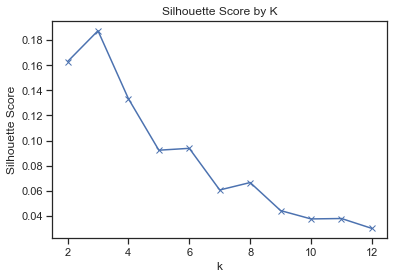

In [74]:
# find optimal cluster
all_X = find_optimal_cluster(train, test)

We can see the clustering is the best at 3. So we'll use 3 as the number of cluster in Gaussian Mixture.
Below cell is for K-mean clustering, not shown here. This version is for Gaussian Mixture shown later.

In [75]:
# all_X_cluster['LABELS'] = cluster.KMeans(n_clusters=3).fit(scaled_data).labels_

# #Analyze labels
# clusters = pd.DataFrame(columns=(all_X_cluster.iloc[:, :]).columns)
# for i in range(0, 3):
#     a = all_X_cluster[all_X_cluster['LABELS'] == i].mean()
#     clusters = clusters.append(a, ignore_index=True)

# #Show information we want
# clusters

##### **[7.3]** Classify clusters using GaussianMixture

In [76]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=9999)
gmm.fit(all_X)
gmm.predict(all_X)

GaussianMixture(n_components=3, random_state=9999)

array([1, 0, 0, ..., 0, 1, 2])

In [77]:
Label = pd.DataFrame(gmm.predict(all_X))
all_X['Label'] = Label

##### **[7.4]** Transform dataset

Imputer and scaler can be selected as need.

In [78]:
X_train = all_X.iloc[:len(y_train), :]
X_test = all_X.iloc[len(y_train):, :]

# fill imputer in 'mean', 'median', 'most_frequent', 'constant'
imputer = 'most_frequent'

# fill scaler in StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()
scaler = StandardScaler()

train, test = transform(train, test, imputer, scaler)

### 8. Split dataset & Save

In [79]:
# Split the train randomly with random_state=8 into 3 different sets: train (60%), validation (20%) and test (20%)
# have set stratify=target
# can add Smote  in the formula if need.
# For example: prep_model_data(df_in, target, resample='', random_state=8)

X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = prep_model_data(train, y_train)

In [80]:
np.save('data/processed/X_train', X_train_res)
np.save('data/processed/y_train', y_train_res)

np.save('data/processed/X_val', X_val_res)
np.save('data/processed/y_val', y_val_res)

np.save('data/processed/X_test', X_test_res)
np.save('data/processed/y_test', y_test_res)